<a href="https://colab.research.google.com/github/moridin04/CCRNFLRL_PROJECT_COM221ML/blob/main/Hangman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Deep Q-Network Agent to Play Hangman**

Roadmap
1. Markov Decision Process (MDP)
- State Space
- Action Space - Discrete(18)
0 - NOOP

1 - FIRE

2 - UP

3 - RIGHT

4 - LEFT

5 - DOWN

6 - UPRIGHT

7 - UPLEFT

8 - DOWNRIGHT

9 - DOWNLEFT

10 - UPFIRE

11 - RIGHTFIRE

12 - LEFTFIRE

13 - DOWNFIRE

14 - UPRIGHTFIRE

15 - UPLEFTFIRE

16 - DOWNRIGHTFIRE

17 - DOWNLEFTFIRE


- Rewards

2. Setting up "Hangman" environment (Gymnasium)
- Observation Encoding
- Action Encoding
- Reward Shaping Strategy

3. Deep Q-Network
- Input Layer (Word State Encoding)
- Hidden Layer (Fully Connected Layers / Embeddings)
- Output Layer (Q-Values of Each Letter)
- Training Algorithm (Experience Replay, Target Network)
- Hyperparameters (Learning Rate, y, Epsilon-Greedy, Replay Buffer Size, Batch Size)

4. Training Process
- Epsilon Decay
- Replay Buffer (filling and sampling)
- Target Network Update Frequency
- Number of Episodes and Training Duration

5. Evaluation Metrics
- Win Rate
- Average Reward per Episode
- Average Number of Steps until Win/Lose

6. Record Multiple Episodes as Video



In [1]:
!pip install --upgrade --pre "gymnasium[atari]" ale-py

import random
import numpy as np
import gymnasium as gym #Hangman Environment
import ale_py
import torch #Neural Networks
import torch.nn as nn
import torch.optim as optim
from collections import deque #Replay Buffer
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
import cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.1/951.1 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

Using device:  cuda


In [3]:
def preprocess(obs):
    # Convert to grayscale and resize
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    return resized.astype(np.float32) / 255.0  # normalize to [0,1]

In [4]:
try:
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    obs, info = env.reset()
    print("Initial observation shape:", obs.shape)
except Exception as e:
    print("Error creating Hangman environment:", e)


Initial observation shape: (210, 160, 3)


In [5]:
class DQN(nn.Module):
    def __init__(self, action_size, in_channels=4):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(7*7*64, 512)
        self.fc2 = nn.Linear(512, action_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [6]:
class ReplayBuffer:
    def __init__(self, max_size=50000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),  # Changed from np.vstack to np.array
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),  # Changed from np.vstack to np.array
            np.array(dones, dtype=np.uint8),
        )

    def __len__(self):
        return len(self.buffer)

In [7]:
class FrameStack:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)

    def reset(self, frame):
        self.frames.clear()
        for _ in range(self.stack_size):
            self.frames.append(frame)
        return self.get_stacked_frames()

    def append(self, frame):
        self.frames.append(frame)
        return self.get_stacked_frames()

    def get_stacked_frames(self):
        return np.stack(self.frames, axis=0)  # Shape: (4, 84, 84)

In [8]:
def train_dqn(episodes=500, gamma=0.99, lr=1e-3, batch_size=32, epsilon_decay=0.995, min_epsilon=0.1):
    env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
    action_size = env.action_space.n
    q_net = DQN(action_size, in_channels=4).to(device)
    target_net = DQN(action_size, in_channels=4).to(device)
    target_net.load_state_dict(q_net.state_dict())  # Initialize target network

    optimizer = optim.Adam(q_net.parameters(), lr=lr)  # ADDED: Define optimizer
    memory = ReplayBuffer()
    frame_stack = FrameStack()

    epsilon = 1.0
    rewards_all = []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = preprocess(obs)
        state = frame_stack.reset(state)  # Get stacked frames
        total_reward = 0
        done = False

        while not done:
            # epsilon-greedy action
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    # Add batch dimension and channel dimension
                    s_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                    q_values = q_net(s_t)
                    action = torch.argmax(q_values).item()

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess(next_obs)
            next_state = frame_stack.append(next_state)  # Get stacked frames

            # Reward shaping
            if reward == -1:
                reward = -0.1  # make penalty smaller
            if terminated and reward == 0:
                reward = -1  # strong penalty for losing
            if terminated and reward > 0:
                reward = +5  # strong reward for winning

            memory.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            # Training step
            if len(memory) >= batch_size:
                states, actions, rewards_, next_states, dones = memory.sample(batch_size)

                # Convert to tensors with proper shape
                states_t = torch.FloatTensor(states).to(device)
                actions_t = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards_t = torch.FloatTensor(rewards_).to(device)
                next_states_t = torch.FloatTensor(next_states).to(device)
                dones_t = torch.BoolTensor(dones).to(device)

                # Current Q values
                current_q = q_net(states_t).gather(1, actions_t).squeeze()

                # Target Q values
                with torch.no_grad():
                    next_q = target_net(next_states_t).max(1)[0]
                    target_q = rewards_t + (~dones_t) * gamma * next_q

                # Compute loss
                loss = nn.MSELoss()(current_q, target_q)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(q_net.parameters(), 1.0)
                optimizer.step()

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards_all.append(total_reward)

        # Update target network
        if ep % 20 == 0:
            target_net.load_state_dict(q_net.state_dict())

        # Logging
        if ep % 50 == 0:
            avg_reward = np.mean(rewards_all[-50:]) if len(rewards_all) >= 50 else np.mean(rewards_all)
            print(f"Episode {ep}, Epsilon: {epsilon:.3f}, Reward: {total_reward:.2f}, Avg Reward (last 50): {avg_reward:.2f}")

    env.close()
    return q_net, rewards_all


In [9]:
q_net, rewards = train_dqn(
    episodes=1000,      # number of episodes to train
    gamma=0.99,         # discount factor
    lr=1e-4,            # learning rate (reduced for stability)
    batch_size=32,      # minibatch size
    epsilon_decay=0.995, # epsilon decay per episode
    min_epsilon=0.05    # final exploration rate
)

Episode 0, Epsilon: 0.995, Reward: -0.10, Avg Reward (last 50): -0.10
Episode 50, Epsilon: 0.774, Reward: -0.10, Avg Reward (last 50): -0.10
Episode 100, Epsilon: 0.603, Reward: -0.10, Avg Reward (last 50): -0.10
Episode 150, Epsilon: 0.469, Reward: -0.10, Avg Reward (last 50): 0.00
Episode 200, Epsilon: 0.365, Reward: 5.00, Avg Reward (last 50): 0.00
Episode 250, Epsilon: 0.284, Reward: -0.10, Avg Reward (last 50): 0.00
Episode 300, Epsilon: 0.221, Reward: -0.10, Avg Reward (last 50): 0.00
Episode 350, Epsilon: 0.172, Reward: -0.10, Avg Reward (last 50): 0.00
Episode 400, Epsilon: 0.134, Reward: -0.10, Avg Reward (last 50): 0.21
Episode 450, Epsilon: 0.104, Reward: -0.10, Avg Reward (last 50): 0.10
Episode 500, Epsilon: 0.081, Reward: -0.10, Avg Reward (last 50): -0.10
Episode 550, Epsilon: 0.063, Reward: -0.10, Avg Reward (last 50): -0.10
Episode 600, Epsilon: 0.050, Reward: -0.10, Avg Reward (last 50): -0.10
Episode 650, Epsilon: 0.050, Reward: -0.10, Avg Reward (last 50): 0.00
Epis

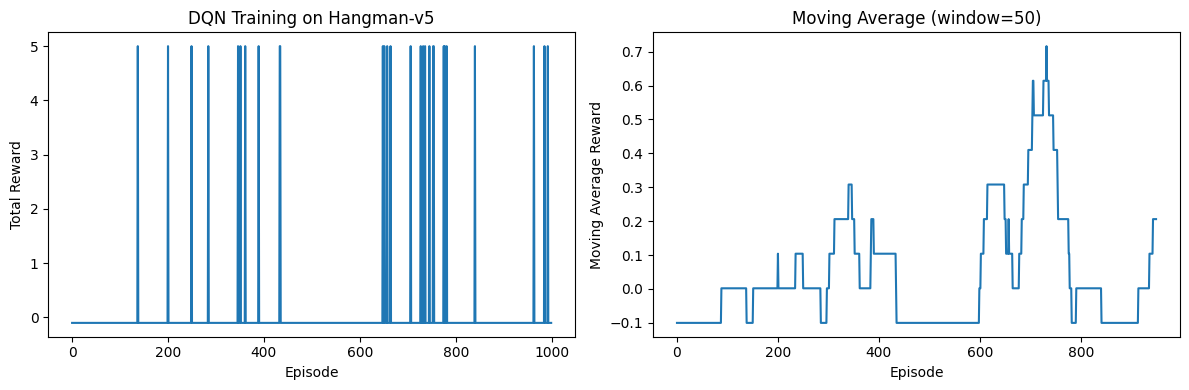

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training on Hangman-v5")

plt.subplot(1, 2, 2)
# Plot moving average
window = 50
moving_avg = [np.mean(rewards[i:i+window]) for i in range(len(rewards)-window)]
plt.plot(moving_avg)
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.title(f"Moving Average (window={window})")

plt.tight_layout()
plt.show()

In [11]:
torch.save(q_net.state_dict(), "hangman_dqn.pth")

In [12]:
def record_episode(env, q_net, filename="hangman_episode.mp4"):
    frames = []
    frame_stack = FrameStack()

    obs, _ = env.reset()
    state = preprocess(obs)
    state = frame_stack.reset(state)
    done = False

    while not done:
        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = q_net(state_t)
            action = torch.argmax(q_values).item()

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = preprocess(next_obs)
        state = frame_stack.append(next_state)

        frame = env.render()
        frames.append(frame)

    # Save video
    imageio.mimsave(filename, frames, fps=10)
    print(f"Episode saved to {filename}")

# Record an episode
env = gym.make("ALE/Hangman-v5", render_mode="rgb_array")
record_episode(env, q_net, "trained_agent.mp4")
env.close()

Episode saved to trained_agent.mp4
